In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import pickle
import json
import torch
import numpy as np
from pyg_data import queryPlanPGDataset_nosplit
from util.util import set_seed, load_model_params
from util.data_transform import *
from util.custom_loss import aleatoric_loss, rmse_loss, bce_loss
import pytorch_lightning as pl
from lcm.roq_model import lcm_pl as roq_model
from lcm.neo_bao_model import lcm_pl as neo_bao_model
from lcm.lero_model import LeroModelPairwise as leroPairwise
from lcm.balsa_model import balsa_simulation, balsa_model
from sklearn.model_selection import KFold,train_test_split
from single_test_lero import test
from util.eval_util import *
from torch_geometric.loader import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [447]:
models_path = os.path.join('.','lightning_models')
results_dir = os.path.join('.','results')

In [448]:
arch = 'roq'
experiment_id = 'job'
files_id = 'job_v2.1'
labeled_data_dir = '../labeled_data/job/'
max_epochs = 1000
patience = 100
num_workers = 10
seed = 0
reload_data = False
target = 'latency' 
n_splits = 10
num_experiments = 5

In [449]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# sets seed for random, numpy, and torch cuda  
set_seed(seed)

torch.set_float32_matmul_precision('high')

# Load train,v alidation, and test datasets
print("loading full dataset")
full_dataset = queryPlanPGDataset_nosplit(
files_id = files_id,
labeled_data_dir=labeled_data_dir,
force_reload=reload_data,
seed = seed,
num_samples = None
)
print("{} queries and {} samples in training dataset: ".format(np.unique(np.array(full_dataset.query_id)).shape[0],full_dataset.len()))

loading full dataset
113 queries and 1469 samples in training dataset: 


In [450]:
qids = np.array(full_dataset.query_id)
unique_qids = np.unique(qids)

In [451]:
unique_qids

array(['10a', '10b', '10c', '11a', '11b', '11c', '11d', '12a', '12b',
       '12c', '13a', '13b', '13c', '13d', '14a', '14b', '14c', '15a',
       '15b', '15c', '15d', '16a', '16b', '16c', '16d', '17a', '17b',
       '17c', '17d', '17e', '17f', '18a', '18b', '18c', '19a', '19b',
       '19c', '19d', '1a', '1b', '1c', '1d', '20a', '20b', '20c', '21a',
       '21b', '21c', '22a', '22b', '22c', '22d', '23a', '23b', '23c',
       '24a', '24b', '25a', '25b', '25c', '26a', '26b', '26c', '27a',
       '27b', '27c', '28a', '28b', '28c', '29a', '29b', '29c', '2a', '2b',
       '2c', '2d', '30a', '30b', '30c', '31a', '31b', '31c', '32a', '32b',
       '33a', '33b', '33c', '3a', '3b', '3c', '4a', '4b', '4c', '5a',
       '5b', '5c', '6a', '6b', '6c', '6d', '6e', '6f', '7a', '7b', '7c',
       '8a', '8b', '8c', '8d', '9a', '9b', '9c', '9d'], dtype='<U3')

In [452]:
train_val_qids, test_qids = train_test_split(
    unique_qids,
    test_size=.1,
    random_state=seed,
    shuffle=True
    )
train_qids, val_qids = train_test_split(
    train_val_qids,
    test_size=.1,
    random_state=seed,
    shuffle=True
    )

In [453]:
train_msk = np.isin(qids,train_qids)
val_msk = np.isin(qids,val_qids)
test_msk = np.isin(qids,test_qids)

train_set = full_dataset[train_msk].copy()
val_set = full_dataset[val_msk].copy()
test_set = full_dataset[test_msk].copy()

print("{} queries and {} samples in training dataset: ".format(np.unique(np.array(train_set.query_id)).shape[0],train_set.len()))
print("{} queries and {} samples in validation dataset: ".format(np.unique(np.array(val_set.query_id)).shape[0],val_set.len()))
print("{} queries and {} samples in test dataset: ".format(np.unique(np.array(test_set.query_id)).shape[0],test_set.len()))

# Perform data transformations on inputs 
# drop_const = dropConst(train_set)
# train_set = drop_const(train_set)
# val_set = drop_const(val_set)
# test_set = drop_const(test_set)

null_imp = nullImputation(train_set)
train_set = null_imp(train_set)
val_set = null_imp(val_set)
test_set = null_imp(test_set)

minmax_scale = minmaxScale(train_set)
train_set = minmax_scale(train_set)
val_set = minmax_scale(val_set)
test_set = minmax_scale(test_set)

if arch != 'lero':
    # Perform data transformations on targets 
    yTransFunc = target_log_transform(train_set, target = target)
    
    train_set = yTransFunc.transform(train_set)
    val_set = yTransFunc.transform(val_set)
    test_set = yTransFunc.transform(test_set)

plan_attr_shape = train_set[0].plan_attr.shape
plan_ord_shape = train_set[0].plan_ord.shape
graph_attr_shape= train_set[0].graph_attr.shape
edge_attr_shape = train_set[0].edge_attr_s.shape
node_attr_shape = train_set[0].x_s.shape

90 queries and 1170 samples in training dataset: 
11 queries and 143 samples in validation dataset: 
12 queries and 156 samples in test dataset: 


/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryData

In [454]:
print('experiment:',experiment_id)
print("Architecture:",arch)

# load model hyper-parameters
config = load_model_params(arch, config_dir='../config',config_file='model_params_job.cfg')
pretrain = config.pop('pretrain',True)
max_epochs = config.pop('max_epochs',max_epochs)
patience = config.pop('patience',patience)
min_delta = config.pop('min_delta',0.001)
batch_size= config['batch_size']


experiment: job
Architecture: roq


In [455]:
loss = rmse_loss()

if arch == 'lero':
    loss = bce_loss()
    model = leroPairwise(
        num_node = node_attr_shape[0], 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
    )
if arch == 'balsa':
    model = balsa_simulation(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
        )

if arch == 'neo':
    model = neo_bao_model(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'neo',
        **config
        )
if arch == 'bao':
    model = neo_bao_model(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'bao',
        **config
        )
if 'roq' in arch:
    loss = aleatoric_loss(device=device)
    model = roq_model(
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        with_var = True, device = device, 
        criterion = loss,
        **config
        )

/database/config/db2inst1/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [456]:
follow_batch = ['x_s']

train_loader = DataLoader(
    train_set, batch_size=batch_size,
    persistent_workers=True,
    shuffle=False, num_workers=num_workers, follow_batch=follow_batch
)
val_loader = DataLoader(
    val_set, batch_size=batch_size,
    persistent_workers=True,
    shuffle=False, num_workers=num_workers, follow_batch=follow_batch
)
test_loader = DataLoader(
    test_set, batch_size=batch_size,
    shuffle=False, num_workers=num_workers, follow_batch=follow_batch,
    persistent_workers=True
)

In [457]:
num_params = sum([np.prod(p.size()) for p in  model.parameters()])
num_params = str(int(num_params/1000))
num_q = str(round(np.unique(np.array(train_set.query_id)).shape[0]/1000))
lr = str(model.lr)[:8]
bs = str(model.batch_size)
# do = str(model.dropout)[:5]
model_name = f'{arch}_{experiment_id}_lr{lr}_bs{bs}_{num_q}kq_{num_params}'
print("model_name:",model_name)
es = pl.callbacks.EarlyStopping(monitor='val_loss',patience=patience, min_delta=min_delta, verbose=True)

logger = pl.loggers.TensorBoardLogger('../lightning_logs', name = model_name)

checkpointing = pl.callbacks.ModelCheckpoint(
    dirpath=models_path,
    monitor='val_loss',
    save_top_k = 1,
    filename=model_name+'{epoch}-{step}-{val_loss:.2f}',
    verbose=True
)

model_name: roq_job_lr0.0038_bs512_0kq_400


In [458]:
if arch == 'balsa':
    if pretrain == True:
        pt_es = pl.callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta=min_delta, verbose=True)
        pretrainer = pl.Trainer(
            max_epochs=5,accelerator='gpu',
            devices=1,
            callbacks = [pt_es,checkpointing],
            logger=logger,
            log_every_n_steps=10
            )
        pretrainer.fit(model,train_loader,val_loader)
        print('Pretraining done. loading best model...')
        model = balsa_simulation.load_from_checkpoint(
            checkpointing.best_model_path,
            num_node = node_attr_shape[0], 
            node_dim = node_attr_shape[1],
            edge_dim = edge_attr_shape[1],#fill_value =0, 
            numPlanFeat=plan_attr_shape,
            numPlanOrdFeat=plan_ord_shape,
            numQueryGraphFeat = graph_attr_shape[0],
            device = device, 
            criterion = loss,
            **config
            ).balsa_model

In [459]:
trainer = pl.Trainer(
    max_epochs=max_epochs,accelerator='gpu',
    devices=1, 
    callbacks = [es, checkpointing], 
    logger=logger, 
    log_every_n_steps=10
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [460]:
trainer.fit(model,train_loader,val_loader)

/database/config/db2inst1/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /database/config/db2inst1/robust_plan_eval/notebooks/lightning_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | aleatoric_loss   | 0      | train
1 | spearmans_corr   | SpearmanCorrCoef | 0      | train
2 | qerror           | qErrorLossClass  | 0      | train
3 | qp_gnn_layers    | ModuleList       | 23.4 K | train
4 | lin_low_node_emb | Linear           | 784    | train
5 | guidelineTCNN    | Sequential       | 172 K  | train
6 | finalMLP         | Sequential       | 199 K  | train
7 | mean_layer       | Sequential       | 2.2 K  | train
8 | std_layer        | Sequential       | 2.2 K  | train
--------------------------------------------------------------
400 K     Trainable params
0   

/database/config/db2inst1/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

/database/config/db2inst1/.venv/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s, v_num=0]

Metric val_loss improved. New best score: 0.703
Epoch 0, global step 3: 'val_loss' reached 0.70279 (best 0.70279), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=0-step=3-val_loss=0.70.ckpt' as top 1


Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 14.03it/s, v_num=0]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.684
Epoch 1, global step 6: 'val_loss' reached 0.68382 (best 0.68382), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=1-step=6-val_loss=0.68.ckpt' as top 1


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 14.19it/s, v_num=0]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.651
Epoch 2, global step 9: 'val_loss' reached 0.65087 (best 0.65087), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=2-step=9-val_loss=0.65.ckpt' as top 1


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 13.16it/s, v_num=0]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.616
Epoch 3, global step 12: 'val_loss' reached 0.61555 (best 0.61555), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=3-step=12-val_loss=0.62.ckpt' as top 1


Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 14.15it/s, v_num=0]

Epoch 4, global step 15: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 3/3 [00:00<00:00, 13.02it/s, v_num=0]

Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 0.491
Epoch 5, global step 18: 'val_loss' reached 0.49105 (best 0.49105), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=5-step=18-val_loss=0.49.ckpt' as top 1


Epoch 6: 100%|██████████| 3/3 [00:00<00:00, 14.25it/s, v_num=0]

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 0.377
Epoch 6, global step 21: 'val_loss' reached 0.37691 (best 0.37691), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=6-step=21-val_loss=0.38.ckpt' as top 1


Epoch 7: 100%|██████████| 3/3 [00:00<00:00, 13.76it/s, v_num=0]

Metric val_loss improved by 0.235 >= min_delta = 0.0. New best score: 0.142
Epoch 7, global step 24: 'val_loss' reached 0.14163 (best 0.14163), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=7-step=24-val_loss=0.14.ckpt' as top 1


Epoch 8: 100%|██████████| 3/3 [00:00<00:00, 13.43it/s, v_num=0]

Metric val_loss improved by 0.210 >= min_delta = 0.0. New best score: -0.069
Epoch 8, global step 27: 'val_loss' reached -0.06881 (best -0.06881), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=8-step=27-val_loss=-0.07.ckpt' as top 1


Epoch 9: 100%|██████████| 3/3 [00:00<00:00, 13.44it/s, v_num=0]

Metric val_loss improved by 0.221 >= min_delta = 0.0. New best score: -0.290
Epoch 9, global step 30: 'val_loss' reached -0.29009 (best -0.29009), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=9-step=30-val_loss=-0.29.ckpt' as top 1


Epoch 10: 100%|██████████| 3/3 [00:00<00:00, 10.84it/s, v_num=0]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: -0.367
Epoch 10, global step 33: 'val_loss' reached -0.36728 (best -0.36728), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=10-step=33-val_loss=-0.37.ckpt' as top 1


Epoch 11: 100%|██████████| 3/3 [00:00<00:00, 12.93it/s, v_num=0]

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: -0.463
Epoch 11, global step 36: 'val_loss' reached -0.46270 (best -0.46270), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=11-step=36-val_loss=-0.46.ckpt' as top 1


Epoch 12: 100%|██████████| 3/3 [00:00<00:00, 12.59it/s, v_num=0]

Epoch 12, global step 39: 'val_loss' was not in top 1


Epoch 13: 100%|██████████| 3/3 [00:00<00:00, 13.29it/s, v_num=0]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: -0.523
Epoch 13, global step 42: 'val_loss' reached -0.52301 (best -0.52301), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=13-step=42-val_loss=-0.52.ckpt' as top 1


Epoch 14: 100%|██████████| 3/3 [00:00<00:00, 11.97it/s, v_num=0]

Epoch 14, global step 45: 'val_loss' was not in top 1


Epoch 15: 100%|██████████| 3/3 [00:00<00:00, 12.21it/s, v_num=0]

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: -0.786
Epoch 15, global step 48: 'val_loss' reached -0.78623 (best -0.78623), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=15-step=48-val_loss=-0.79.ckpt' as top 1


Epoch 16: 100%|██████████| 3/3 [00:00<00:00, 12.73it/s, v_num=0]

Epoch 16, global step 51: 'val_loss' was not in top 1


Epoch 17: 100%|██████████| 3/3 [00:00<00:00, 12.18it/s, v_num=0]

Epoch 17, global step 54: 'val_loss' was not in top 1


Epoch 18: 100%|██████████| 3/3 [00:00<00:00, 12.58it/s, v_num=0]

Epoch 18, global step 57: 'val_loss' was not in top 1


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 12.78it/s, v_num=0]

Epoch 19, global step 60: 'val_loss' was not in top 1


Epoch 20: 100%|██████████| 3/3 [00:00<00:00, 12.41it/s, v_num=0]

Epoch 20, global step 63: 'val_loss' was not in top 1


Epoch 21: 100%|██████████| 3/3 [00:00<00:00, 12.94it/s, v_num=0]

Epoch 21, global step 66: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 3/3 [00:00<00:00, 12.24it/s, v_num=0]

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: -0.937
Epoch 22, global step 69: 'val_loss' reached -0.93683 (best -0.93683), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=22-step=69-val_loss=-0.94.ckpt' as top 1


Epoch 23: 100%|██████████| 3/3 [00:00<00:00, 11.92it/s, v_num=0]

Epoch 23, global step 72: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 13.12it/s, v_num=0]

Epoch 24, global step 75: 'val_loss' was not in top 1


Epoch 25: 100%|██████████| 3/3 [00:00<00:00, 12.12it/s, v_num=0]

Epoch 25, global step 78: 'val_loss' was not in top 1


Epoch 26: 100%|██████████| 3/3 [00:00<00:00, 12.18it/s, v_num=0]

Epoch 26, global step 81: 'val_loss' was not in top 1


Epoch 27: 100%|██████████| 3/3 [00:00<00:00, 11.30it/s, v_num=0]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: -0.998
Epoch 27, global step 84: 'val_loss' reached -0.99807 (best -0.99807), saving model to '/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=27-step=84-val_loss=-1.00.ckpt' as top 1


Epoch 28: 100%|██████████| 3/3 [00:00<00:00, 11.98it/s, v_num=0]

Epoch 28, global step 87: 'val_loss' was not in top 1


Epoch 29: 100%|██████████| 3/3 [00:00<00:00, 12.06it/s, v_num=0]

Epoch 29, global step 90: 'val_loss' was not in top 1


Epoch 30: 100%|██████████| 3/3 [00:00<00:00, 12.13it/s, v_num=0]

Epoch 30, global step 93: 'val_loss' was not in top 1


Epoch 31: 100%|██████████| 3/3 [00:00<00:00, 11.93it/s, v_num=0]

Epoch 31, global step 96: 'val_loss' was not in top 1


Epoch 32: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s, v_num=0]

Epoch 32, global step 99: 'val_loss' was not in top 1


Epoch 33: 100%|██████████| 3/3 [00:00<00:00, 11.90it/s, v_num=0]

Epoch 33, global step 102: 'val_loss' was not in top 1


Epoch 34: 100%|██████████| 3/3 [00:00<00:00, 10.71it/s, v_num=0]

Epoch 34, global step 105: 'val_loss' was not in top 1


Epoch 35: 100%|██████████| 3/3 [00:00<00:00, 13.03it/s, v_num=0]

Epoch 35, global step 108: 'val_loss' was not in top 1


Epoch 36: 100%|██████████| 3/3 [00:00<00:00, 12.35it/s, v_num=0]

Epoch 36, global step 111: 'val_loss' was not in top 1


Epoch 37: 100%|██████████| 3/3 [00:00<00:00, 10.71it/s, v_num=0]

Epoch 37, global step 114: 'val_loss' was not in top 1


Epoch 38: 100%|██████████| 3/3 [00:00<00:00, 11.69it/s, v_num=0]

Epoch 38, global step 117: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 3/3 [00:00<00:00, 12.37it/s, v_num=0]

Epoch 39, global step 120: 'val_loss' was not in top 1


Epoch 40: 100%|██████████| 3/3 [00:00<00:00, 12.33it/s, v_num=0]

Epoch 40, global step 123: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 3/3 [00:00<00:00, 12.21it/s, v_num=0]

Epoch 41, global step 126: 'val_loss' was not in top 1


Epoch 42: 100%|██████████| 3/3 [00:00<00:00, 11.77it/s, v_num=0]

Epoch 42, global step 129: 'val_loss' was not in top 1


Epoch 43: 100%|██████████| 3/3 [00:00<00:00, 12.14it/s, v_num=0]

Epoch 43, global step 132: 'val_loss' was not in top 1


Epoch 44: 100%|██████████| 3/3 [00:00<00:00, 12.60it/s, v_num=0]

Epoch 44, global step 135: 'val_loss' was not in top 1


Epoch 45: 100%|██████████| 3/3 [00:00<00:00, 12.62it/s, v_num=0]

Epoch 45, global step 138: 'val_loss' was not in top 1


Epoch 46: 100%|██████████| 3/3 [00:00<00:00, 12.55it/s, v_num=0]

Epoch 46, global step 141: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 3/3 [00:00<00:00, 12.06it/s, v_num=0]

Epoch 47, global step 144: 'val_loss' was not in top 1


Epoch 48: 100%|██████████| 3/3 [00:00<00:00, 11.84it/s, v_num=0]

Epoch 48, global step 147: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.80it/s, v_num=0]

Epoch 49, global step 150: 'val_loss' was not in top 1


Epoch 50: 100%|██████████| 3/3 [00:00<00:00, 11.40it/s, v_num=0]

Epoch 50, global step 153: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 3/3 [00:00<00:00, 12.24it/s, v_num=0]

Epoch 51, global step 156: 'val_loss' was not in top 1


Epoch 52: 100%|██████████| 3/3 [00:00<00:00, 12.06it/s, v_num=0]

Epoch 52, global step 159: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s, v_num=0]

Epoch 53, global step 162: 'val_loss' was not in top 1


Epoch 54: 100%|██████████| 3/3 [00:00<00:00, 12.21it/s, v_num=0]

Epoch 54, global step 165: 'val_loss' was not in top 1


Epoch 55: 100%|██████████| 3/3 [00:00<00:00, 11.41it/s, v_num=0]

Epoch 55, global step 168: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 3/3 [00:00<00:00, 12.15it/s, v_num=0]

Epoch 56, global step 171: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 3/3 [00:00<00:00, 11.95it/s, v_num=0]

Epoch 57, global step 174: 'val_loss' was not in top 1


Epoch 58: 100%|██████████| 3/3 [00:00<00:00, 11.90it/s, v_num=0]

Epoch 58, global step 177: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 3/3 [00:00<00:00, 10.82it/s, v_num=0]

Epoch 59, global step 180: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 3/3 [00:00<00:00, 12.20it/s, v_num=0]

Epoch 60, global step 183: 'val_loss' was not in top 1


Epoch 61: 100%|██████████| 3/3 [00:00<00:00, 11.57it/s, v_num=0]

Epoch 61, global step 186: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 3/3 [00:00<00:00, 11.43it/s, v_num=0]

Epoch 62, global step 189: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 3/3 [00:00<00:00, 12.04it/s, v_num=0]

Epoch 63, global step 192: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 3/3 [00:00<00:00, 11.04it/s, v_num=0]

Epoch 64, global step 195: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 3/3 [00:00<00:00, 10.99it/s, v_num=0]

Epoch 65, global step 198: 'val_loss' was not in top 1


Epoch 66: 100%|██████████| 3/3 [00:00<00:00, 11.50it/s, v_num=0]

Epoch 66, global step 201: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 3/3 [00:00<00:00, 11.34it/s, v_num=0]

Epoch 67, global step 204: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 3/3 [00:00<00:00, 11.68it/s, v_num=0]

Epoch 68, global step 207: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 3/3 [00:00<00:00, 11.14it/s, v_num=0]

Epoch 69, global step 210: 'val_loss' was not in top 1


Epoch 70: 100%|██████████| 3/3 [00:00<00:00, 12.18it/s, v_num=0]

Epoch 70, global step 213: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s, v_num=0]

Epoch 71, global step 216: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 3/3 [00:00<00:00, 11.71it/s, v_num=0]

Epoch 72, global step 219: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s, v_num=0]

Epoch 73, global step 222: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 3/3 [00:00<00:00,  8.63it/s, v_num=0]

Epoch 74, global step 225: 'val_loss' was not in top 1


Epoch 75: 100%|██████████| 3/3 [00:00<00:00, 12.13it/s, v_num=0]

Epoch 75, global step 228: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 3/3 [00:00<00:00, 12.15it/s, v_num=0]

Epoch 76, global step 231: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 3/3 [00:00<00:00, 12.61it/s, v_num=0]

Monitored metric val_loss did not improve in the last 50 records. Best score: -0.998. Signaling Trainer to stop.
Epoch 77, global step 234: 'val_loss' was not in top 1


Epoch 77: 100%|██████████| 3/3 [00:00<00:00, 12.35it/s, v_num=0]


In [461]:
print('Best {} model saved in \n{}'.format(model_name,checkpointing.best_model_path))

Best roq_job_lr0.0038_bs512_0kq_400 model saved in 
/database/config/db2inst1/robust_plan_eval/notebooks/lightning_models/roq_job_lr0.0038_bs512_0kq_400epoch=27-step=84-val_loss=-1.00.ckpt


In [462]:
if arch == 'lero':
    lero_pairwise = leroPairwise.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
        )
    model=lero_pairwise.lero_model
if arch == 'balsa':
    balsa = balsa_model.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],#fill_value =0, 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        **config
        )
if 'neo' in arch:
    neo = neo_bao_model.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'neo',
        **config
        )

if 'bao' in arch:
    bao = neo_bao_model.load_from_checkpoint(
        checkpointing.best_model_path,
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1],
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        device = device, 
        criterion = loss,
        architecture = 'bao',
        **config
        )
if 'roq' in arch:
    roq = roq_model.load_from_checkpoint(
        checkpointing.best_model_path, 
        num_node = node_attr_shape[0], 
        node_dim = node_attr_shape[1],
        edge_dim = edge_attr_shape[1], 
        numPlanFeat=plan_attr_shape,
        numPlanOrdFeat=plan_ord_shape,
        numQueryGraphFeat = graph_attr_shape[0],
        with_var = True, device = device, 
        criterion = loss,
        **config
        )

In [463]:
ypreds_test = trainer.predict(model, test_loader)
ypreds_test = torch.vstack(ypreds_test)
if arch != 'lero':
    ypreds_test=yTransFunc.inverse_transform(torch.Tensor(ypreds_test))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]


In [464]:
lero_subopt,lero_runtime,_ = evaluate_method(
    ypreds_test[:,0],ypreds_test[:,1],test_set, 
    strategy='baseline ml'
)

baseline ml  : corr : (np.float64(0.879437029922222), np.float64(1.6446379434378336e-51))
queries with no plans after pruning: 0
evaluation time: 0.003209352493286133



,5.0,7.0,8.0,9.0,10.0,11.0,14.0,18.0,20.0,overall q_error
count,13.000000,13.000000,26.000000,13.000000,13.000000,26.000000,13.000000,13.000000,26.000000,156.000000
mean,7.312111,2.618566,1.628558,1.390581,2.235841,1.605698,3.656896,1.707068,2.801931,2.582787
std,6.235503,2.753206,0.307440,0.357683,0.537741,0.437933,3.501274,0.527778,3.082015,2.943730
min,1.126659,1.008574,1.065738,1.090499,1.030751,1.121264,1.131866,1.115613,1.038091,1.008574
0%,1.126659,1.008574,1.065738,1.090499,1.030751,1.121264,1.131866,1.115613,1.038091,1.008574
10%,1.166756,1.015374,1.242801,1.199655,1.767594,1.121931,1.157306,1.252366,1.038594,1.110326
20%,1.266593,1.019371,1.481794,1.207904,1.780720,1.372765,1.222153,1.310927,1.076790,1.181734
30%,1.681547,1.172240,1.511982,1.208127,1.817091,1.399443,1.348564,1.403338,1.114814,1.285125
40%,1.962090,1.507341,1.528651,1.208276,2.303883,1.416230,1.621213,1.465250,1.143348,1.457197
50%,8.920841,1.649513,1.613258,1.222012,2.423294,1.455216,2.584325,1.486433,1.162019,1.516772


ml_subopt                                                              \
            5.0       7.0       8.0       9.0      10.0      11.0      14.0   
count  1.000000  1.000000  2.000000  1.000000  1.000000  2.000000  1.000000   
mean   5.781667  1.575382  1.101414  1.863757  1.626461  1.135103  1.061296   
std         NaN       NaN  0.032264       NaN       NaN  0.177037       NaN   
min    5.781667  1.575382  1.078600  1.863757  1.626461  1.009919  1.061296   
0%     5.781667  1.575382  1.078600  1.863757  1.626461  1.009919  1.061296   
10%    5.781667  1.575382  1.083163  1.863757  1.626461  1.034956  1.061296   
20%    5.781667  1.575382  1.087726  1.863757  1.626461  1.059993  1.061296   
30%    5.781667  1.575382  1.092289  1.863757  1.626461  1.085029  1.061296   
40%    5.781667  1.575382  1.096852  1.863757  1.626461  1.110066  1.061296   
50%    5.781667  1.575382  1.101415  1.863757  1.626461  1.135103  1.061296   
60%    5.781667  1.575382  1.105977  1.863757  1.626461  1.160140  1.061296   
70%    5.781667  1.575382  1.110540  1.863757  1.626461  1.185177  1.061296   
80%    5.781667  1.575382  1.115103  1.863757  1.626461  1.210213  1.061296   
90%    5.781667  1.575382  1.119666  1.863757  1.626461  1.235250  1.061296   
max    5.781667  1.575382  1.124229  1.863757  1.626461  1.260287  1.061296   

                                    db2_subopt                                \
      18.0      20.0 overall subopt        5.0       7.0        8.0      9.0   
count  1.0  2.000000      12.000000   1.000000  1.000000   2.000000  1.00000   
mean   1.0  1.394690       1.680915   1.011482  1.962704   6.160443  3.74519   
std    NaN  0.220476       1.321968        NaN       NaN   7.186811      NaN   
min    1.0  1.238790       1.000000   1.011482  1.962704   1.078600  3.74519   
0%     1.0  1.238790       1.000000   1.011482  1.962704   1.078600  3.74519   
10%    1.0  1.269970       1.015057   1.011482  1.962704   2.094969  3.74519   
20%    1.0  1.301150       1.064757   1.011482  1.962704   3.111337  3.74519   
30%    1.0  1.332330       1.092289   1.011482  1.962704   4.127706  3.74519   
40%    1.0  1.363510       1.170053   1.011482  1.962704   5.144074  3.74519   
50%    1.0  1.394690       1.249539   1.011482  1.962704   6.160443  3.74519   
60%    1.0  1.425870       1.434469   1.011482  1.962704   7.176812  3.74519   
70%    1.0  1.457050       1.567944   1.011482  1.962704   8.193180  3.74519   
80%    1.0  1.488230       1.616245   1.011482  1.962704   9.209549  3.74519   
90%    1.0  1.519410       1.840027   1.011482  1.962704  10.225917  3.74519   
max    1.0  1.550590       5.781667   1.011482  1.962704  11.242286  3.74519   

                                                                   
           10.0      11.0      14.0 18.0      20.0 overall subopt  
count  1.000000  2.000000  1.000000  1.0  2.000000      12.000000  
mean   1.018869  1.675327  1.419909  1.0  1.631877       2.424454  
std         NaN  0.338386       NaN  NaN  0.114958       2.876864  
min    1.018869  1.436051  1.419909  1.0  1.550590       1.000000  
0%     1.018869  1.436051  1.419909  1.0  1.550590       1.000000  
10%    1.018869  1.483906  1.419909  1.0  1.566847       1.012220  
20%    1.018869  1.531761  1.419909  1.0  1.583105       1.030815  
30%    1.018869  1.579616  1.419909  1.0  1.599362       1.180993  
40%    1.018869  1.627472  1.419909  1.0  1.615620       1.426366  
50%    1.018869  1.675327  1.419909  1.0  1.631877       1.493321  
60%    1.018869  1.723182  1.419909  1.0  1.648135       1.648135  
70%    1.018869  1.771037  1.419909  1.0  1.664392       1.854171  
80%    1.018869  1.818892  1.419909  1.0  1.680650       1.953083  
90%    1.018869  1.866747  1.419909  1.0  1.696907       3.566941  
max    1.018869  1.914602  1.419909  1.0  1.713165      11.242286

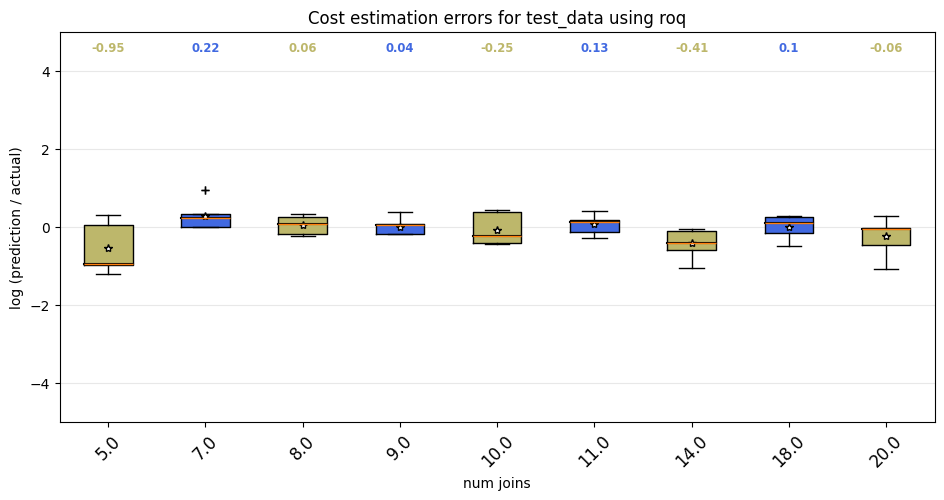

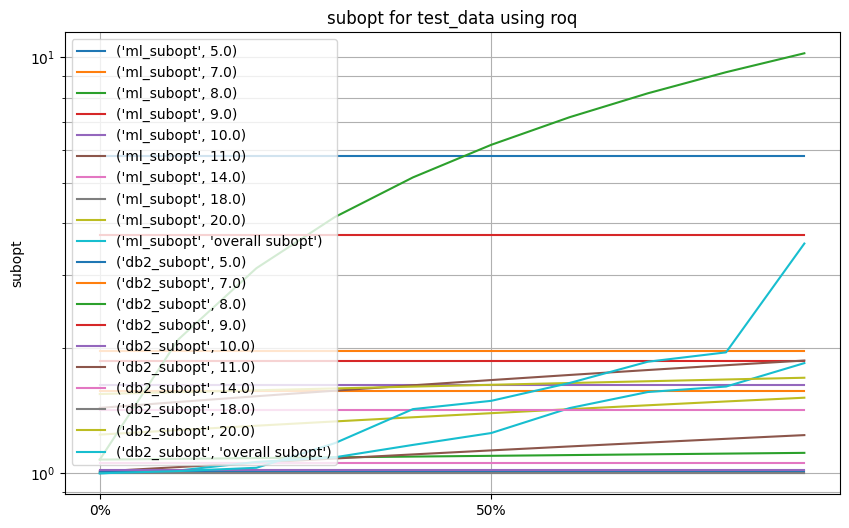

In [465]:
lero_qerror, _ = lcm_model_eval(
    test_set, ypreds_test[:,0], 
    dataset_label = 'test_data', model_label = arch
    ,load_from_disk=False, files_id = files_id,show_fig=False,
    results_dir = results_dir
)

In [466]:
ypreds_test = ypreds_test[:,0].squeeze().numpy()
if arch == 'lero':
    ypreds_test*=-1
targets = test_set.y.squeeze().numpy()

In [467]:
spearmanr_coef8, _ = compute_spearmanr(ypreds_test,targets)

Spearman's Rank Correlation Coefficient: 0.879437029922222
P-value: 1.6446379434378336e-51
There is a significant correlation.


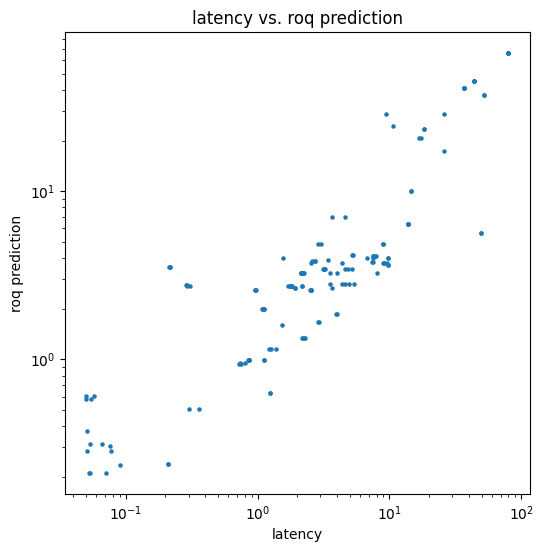

In [468]:
from util.eval_util import plotxvsy

plotxvsy(targets,ypreds_test, xl='latency', yl=f'{arch} prediction',scale='log')

In [469]:
sprearmans_coef = []
for id in test_qids:
    query_msk = (np.array(test_set.query_id) == id)
    temp, _ = compute_spearmanr(ypreds_test[query_msk],targets[query_msk], verbose=False)
    sprearmans_coef.append(temp)

In [470]:
np.array(sprearmans_coef)

array([ 0.94549986,  0.33701786,  0.89235486,  0.51750732,  0.80518294,
        0.76243385,  0.76966176,  0.8951478 ,  0.88353699,  0.75253662,
       -0.7790085 ,  0.51862513])

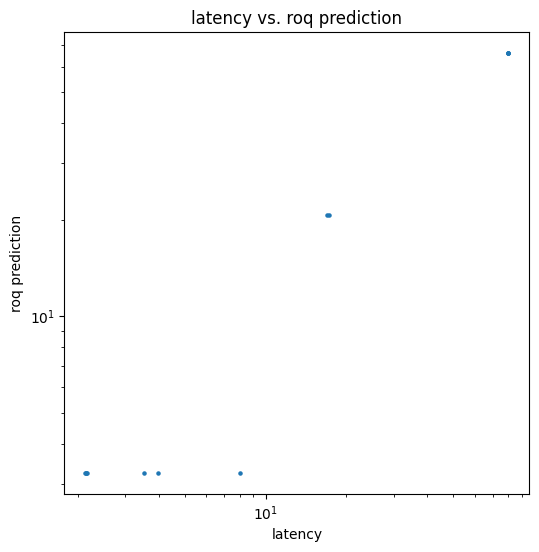

In [471]:
query_msk = (np.array(test_set.query_id) == test_qids[8])
plotxvsy(targets[query_msk],ypreds_test[query_msk], xl='latency', yl=f'{arch} prediction',scale='log')
